# 动态路径规划可视化演示

这个notebook展示了各种路径规划算法的动态搜索过程，包括：

## 🎯 功能特性
- **实时搜索过程**：观察算法如何逐步探索状态空间
- **多算法对比**：A*, RRT, Dijkstra等算法的搜索模式对比
- **交互式控制**：可以暂停、前进、后退观察搜索步骤
- **性能统计**：实时显示搜索统计信息

## 📊 展示内容
1. 算法搜索过程的逐步动画
2. 开放集和关闭集的动态变化
3. 搜索前沿的扩展模式
4. 最终路径的生成过程

In [1]:
# 导入必要的库
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Button, Slider
from IPython.display import HTML, display
import time
import warnings
warnings.filterwarnings('ignore')

# 设置matplotlib参数
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['font.size'] = 10

# 添加项目路径
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.append(project_root)

print("📚 导入完成")
print(f"🔧 工作目录: {os.getcwd()}")
print(f"📁 项目根目录: {project_root}")

📚 导入完成
🔧 工作目录: /Users/kk/Desktop/robot
📁 项目根目录: /Users/kk/Desktop


In [2]:
# 导入项目模块
try:
    from src.environment.scenario import get_scenario, SCENARIOS
    from src.planning.a_star import AStarPlanner
    from src.planning.rrt import RRTPlanner
    from src.planning.dijkstra import DijkstraPlanner
    from src.planning.potential_field import PotentialFieldPlanner
    from src.planning.base_planner import BasePlanner
    
    print("✅ 项目模块导入成功")
    
except ImportError as e:
    print(f"❌ 导入错误: {e}")
    print("请确保在项目根目录运行")

✅ 项目模块导入成功


## 1. 场景设置与算法初始化

首先创建测试环境和初始化各种规划算法。

🌍 创建测试场景...
📍 场景信息:
   地图尺寸: 15 x 12
   起点: (1, 1)
   终点: (14, 11)
   障碍物数量: 6
🤖 算法初始化完成: ['A*', 'RRT', 'Dijkstra', 'Potential_Field']


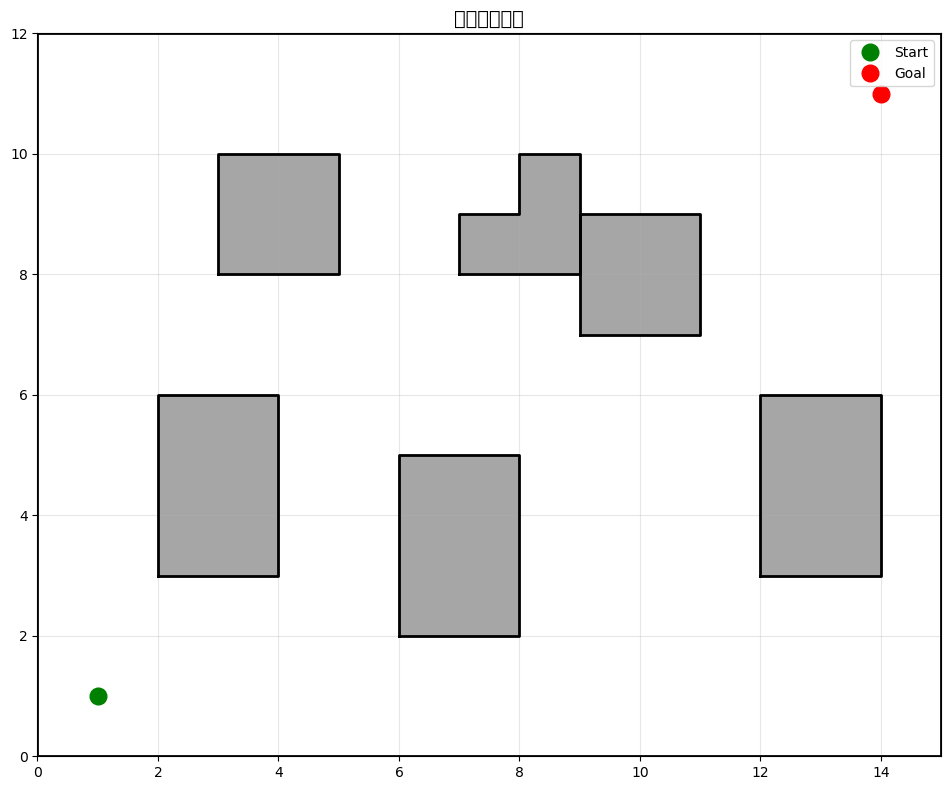

In [3]:
# 创建测试场景
print("🌍 创建测试场景...")

# 可以选择不同的场景
# env = get_scenario('simple')    # 简单场景
env = get_scenario('complex')   # 复杂场景
# env = get_scenario('maze')      # 迷宫场景

print(f"📍 场景信息:")
print(f"   地图尺寸: {env.width} x {env.height}")
print(f"   起点: {env.start}")
print(f"   终点: {env.goal}")
print(f"   障碍物数量: {len(env.obstacles)}")

# 初始化算法
planners = {
    'A*': AStarPlanner(resolution=0.4, heuristic_weight=1.0),
    'RRT': RRTPlanner(max_iterations=1000, step_size=0.5),
    'Dijkstra': DijkstraPlanner(resolution=0.5),
    'Potential_Field': PotentialFieldPlanner(attractive_gain=1.0, repulsive_gain=3.0)
}

print(f"🤖 算法初始化完成: {list(planners.keys())}")

# 可视化场景
fig, ax = plt.subplots(figsize=(10, 8))
env.visualize(ax=ax)
ax.set_title('测试场景环境', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. 动态搜索过程可视化类

实现一个通用的动态可视化类，能够展示不同算法的搜索过程。

In [4]:
class DynamicPlanningVisualizer:
    """动态路径规划可视化器"""
    
    def __init__(self, environment, planner, figsize=(12, 10)):
        self.env = environment
        self.planner = planner
        self.figsize = figsize
        
        # 动画相关
        self.fig = None
        self.ax = None
        self.animation = None
        self.current_step = 0
        self.total_steps = 0
        
        # 搜索数据
        self.search_history = []
        self.final_path = None
        self.metrics = None
        
    def run_planning_with_history(self, start, goal):
        """执行规划并记录搜索历史"""
        print(f"🎯 开始 {self.planner.name} 算法规划...")
        
        # 执行规划
        start_time = time.time()
        path, metrics = self.planner.plan_with_metrics(start, goal, self.env)
        planning_time = time.time() - start_time
        
        self.final_path = path
        self.metrics = metrics
        
        # 获取搜索历史
        self._extract_search_history()
        
        print(f"✅ 规划完成:")
        print(f"   成功: {metrics.success}")
        print(f"   时间: {metrics.planning_time:.3f}s")
        if path:
            print(f"   路径点数: {len(path)}")
            print(f"   路径长度: {metrics.path_length:.2f}m")
            print(f"   探索节点: {metrics.num_nodes_explored}")
        print(f"   搜索步骤: {len(self.search_history)}")
        
        return path, metrics
    
    def _extract_search_history(self):
        """提取搜索历史数据"""
        self.search_history = []
        
        if hasattr(self.planner, 'open_set_history') and self.planner.open_set_history:
            # A*算法的历史
            for i in range(len(self.planner.open_set_history)):
                step_data = {
                    'type': 'astar',
                    'open_set': self.planner.open_set_history[i],
                    'closed_set': self.planner.closed_set_history[i] if i < len(self.planner.closed_set_history) else set(),
                    'current_node': self.planner.current_node_history[i] if i < len(self.planner.current_node_history) else None
                }
                self.search_history.append(step_data)
                
        elif hasattr(self.planner, 'visited_nodes') and self.planner.visited_nodes:
            # Dijkstra算法的历史
            for i in range(len(self.planner.visited_nodes)):
                step_data = {
                    'type': 'dijkstra',
                    'visited_nodes': self.planner.visited_nodes[:i+1],
                    'current_node': self.planner.visited_nodes[i]
                }
                self.search_history.append(step_data)
                
        elif hasattr(self.planner, 'tree_nodes') and hasattr(self.planner, 'tree_edges'):
            # RRT算法的历史
            for i in range(1, len(self.planner.tree_nodes) + 1):
                step_data = {
                    'type': 'rrt',
                    'tree_nodes': self.planner.tree_nodes[:i],
                    'tree_edges': self.planner.tree_edges[:i-1] if i > 1 else [],
                    'current_node': self.planner.tree_nodes[i-1] if i <= len(self.planner.tree_nodes) else None
                }
                self.search_history.append(step_data)
        
        self.total_steps = len(self.search_history)
    
    def create_static_visualization(self, step=-1):
        """创建静态可视化"""
        fig, ax = plt.subplots(figsize=self.figsize)
        
        # 绘制环境
        self.env.visualize(ax=ax, show_grid=False)
        
        # 绘制搜索过程
        if step == -1:
            step = self.total_steps - 1
        
        if 0 <= step < len(self.search_history):
            self._draw_search_step(ax, step)
        
        # 绘制最终路径
        if self.final_path:
            path_array = np.array(self.final_path)
            ax.plot(path_array[:, 0], path_array[:, 1], 'r-', linewidth=3, 
                   label='Final Path', alpha=0.8, zorder=10)
        
        # 添加信息
        title = f'{self.planner.name} Algorithm'
        if 0 <= step < len(self.search_history):
            title += f' - Step {step + 1}/{self.total_steps}'
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        if self.metrics:
            info_text = f'Success: {self.metrics.success}\n'
            info_text += f'Time: {self.metrics.planning_time:.3f}s\n'
            if self.final_path:
                info_text += f'Path Length: {self.metrics.path_length:.2f}m\n'
            info_text += f'Nodes: {self.metrics.num_nodes_explored}'
            
            ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
                   verticalalignment='top', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        
        ax.legend()
        plt.tight_layout()
        return fig, ax
    
    def _draw_search_step(self, ax, step):
        """绘制特定步骤的搜索状态"""
        if step >= len(self.search_history):
            return
        
        step_data = self.search_history[step]
        
        if step_data['type'] == 'astar':
            # 绘制A*搜索状态
            if step_data['closed_set']:
                closed_x = [node.x for node in step_data['closed_set']]
                closed_y = [node.y for node in step_data['closed_set']]
                ax.scatter(closed_x, closed_y, c='lightblue', s=20, alpha=0.6, 
                          label='Closed Set', zorder=3)
            
            if step_data['open_set']:
                open_x = [node.x for node in step_data['open_set']]
                open_y = [node.y for node in step_data['open_set']]
                ax.scatter(open_x, open_y, c='yellow', s=30, alpha=0.8, 
                          label='Open Set', zorder=4)
            
            if step_data['current_node']:
                current = step_data['current_node']
                ax.scatter(current.x, current.y, c='red', s=100, marker='*', 
                          label='Current Node', zorder=5)
                
        elif step_data['type'] == 'dijkstra':
            # 绘制Dijkstra搜索状态
            if step_data['visited_nodes']:
                # 根据访问顺序着色
                colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(step_data['visited_nodes'])))
                
                for i, node in enumerate(step_data['visited_nodes']):
                    ax.scatter(node.x, node.y, c=[colors[i]], s=30, alpha=0.8, 
                              edgecolors='black', linewidth=0.5, zorder=3)
            
            if step_data['current_node']:
                current = step_data['current_node']
                ax.scatter(current.x, current.y, c='red', s=100, marker='*', 
                          label='Current Node', zorder=5)
                
        elif step_data['type'] == 'rrt':
            # 绘制RRT搜索状态
            if step_data['tree_nodes']:
                # 绘制树节点
                tree_x = [node[0] for node in step_data['tree_nodes']]
                tree_y = [node[1] for node in step_data['tree_nodes']]
                ax.scatter(tree_x, tree_y, c='lightgreen', s=20, alpha=0.8, 
                          label='Tree Nodes', zorder=3)
            
            if step_data['tree_edges']:
                # 绘制树边
                for edge in step_data['tree_edges']:
                    ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], 
                           'g-', alpha=0.6, linewidth=1, zorder=2)
            
            if step_data['current_node']:
                current = step_data['current_node']
                ax.scatter(current[0], current[1], c='red', s=100, marker='*', 
                          label='New Node', zorder=5)
    
    def create_animation(self, interval=200, save_gif=False, filename=None):
        """创建动画"""
        if not self.search_history:
            print("❌ 没有搜索历史数据")
            return None
        
        print(f"🎬 创建动画，共 {self.total_steps} 帧...")
        
        self.fig, self.ax = plt.subplots(figsize=self.figsize)
        
        def animate(frame):
            self.ax.clear()
            
            # 绘制环境
            self.env.visualize(ax=self.ax, show_grid=False)
            
            # 绘制搜索过程
            self._draw_search_step(self.ax, frame)
            
            # 绘制最终路径（在最后几帧）
            if frame >= self.total_steps - 10 and self.final_path:
                path_array = np.array(self.final_path)
                self.ax.plot(path_array[:, 0], path_array[:, 1], 'r-', linewidth=3, 
                           label='Final Path', alpha=0.8, zorder=10)
            
            # 设置标题
            title = f'{self.planner.name} Algorithm - Step {frame + 1}/{self.total_steps}'
            self.ax.set_title(title, fontsize=14, fontweight='bold')
            
            # 添加进度信息
            progress = (frame + 1) / self.total_steps * 100
            info_text = f'Progress: {progress:.1f}%\n'
            if self.metrics:
                info_text += f'Target Nodes: {self.metrics.num_nodes_explored}'
            
            self.ax.text(0.02, 0.98, info_text, transform=self.ax.transAxes, 
                        verticalalignment='top', fontsize=10,
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
            
            if frame >= self.total_steps - 5:  # 最后几帧显示图例
                self.ax.legend()
        
        # 创建动画
        frames = min(self.total_steps, 100)  # 限制最大帧数
        if frames < self.total_steps:
            # 如果步骤太多，采样显示
            frame_indices = np.linspace(0, self.total_steps - 1, frames, dtype=int)
        else:
            frame_indices = range(self.total_steps)
        
        self.animation = animation.FuncAnimation(
            self.fig, animate, frames=frame_indices,
            interval=interval, blit=False, repeat=True
        )
        
        if save_gif and filename:
            print(f"💾 保存动画到 {filename}...")
            self.animation.save(filename, writer='pillow', fps=5)
            print("✅ 动画保存完成")
        
        plt.tight_layout()
        return self.animation

print("✅ 动态可视化类创建完成")

✅ 动态可视化类创建完成


## 3. A* 算法动态演示

展示A*算法的搜索过程，包括开放集和关闭集的动态变化。

🌟 A* 算法动态演示
🎯 开始 A* 算法规划...
✅ 规划完成:
   成功: False
   时间: 0.594s
   搜索步骤: 28

📊 显示最终结果:


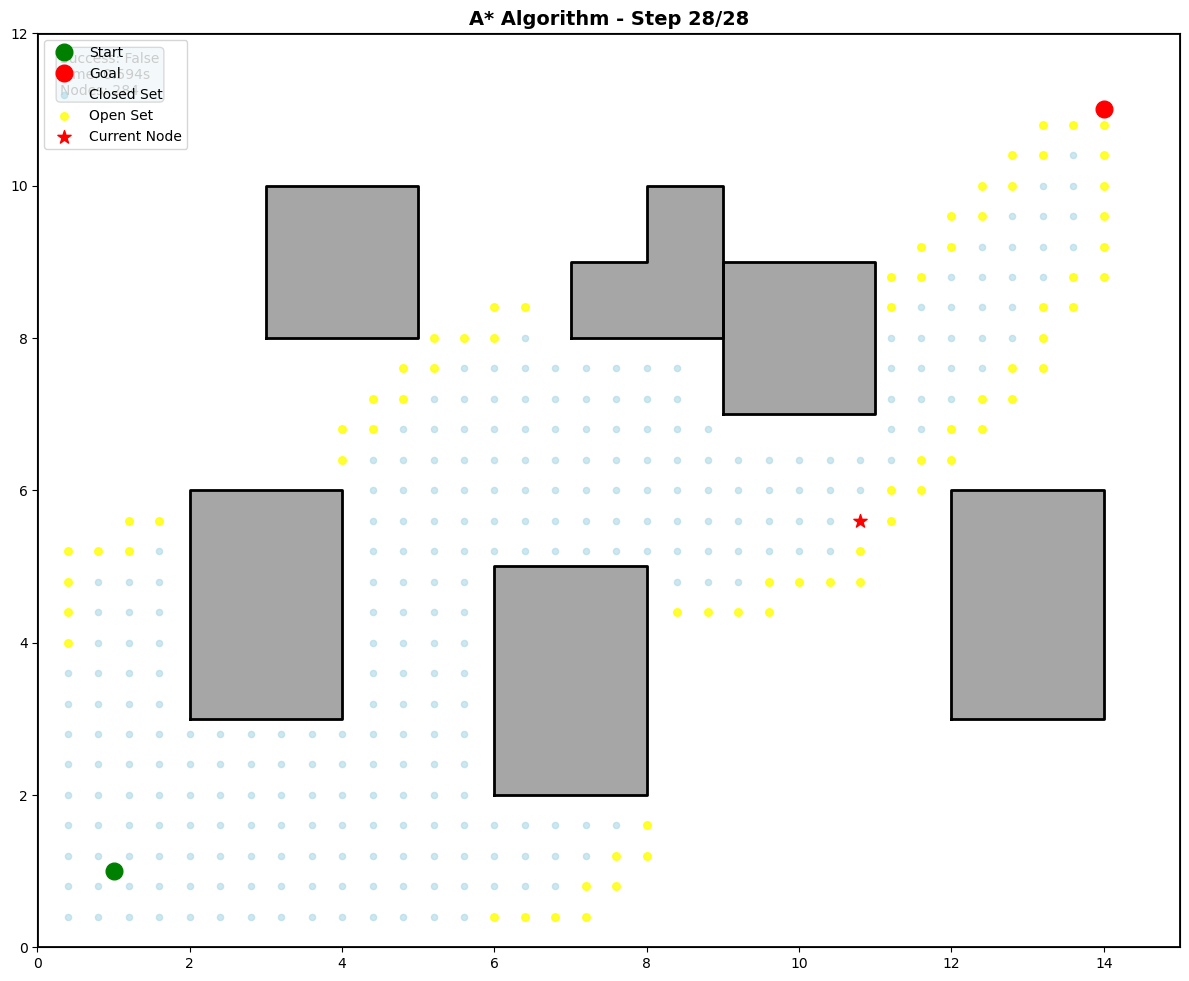


🎬 创建搜索过程动画:
🎬 创建动画，共 28 帧...


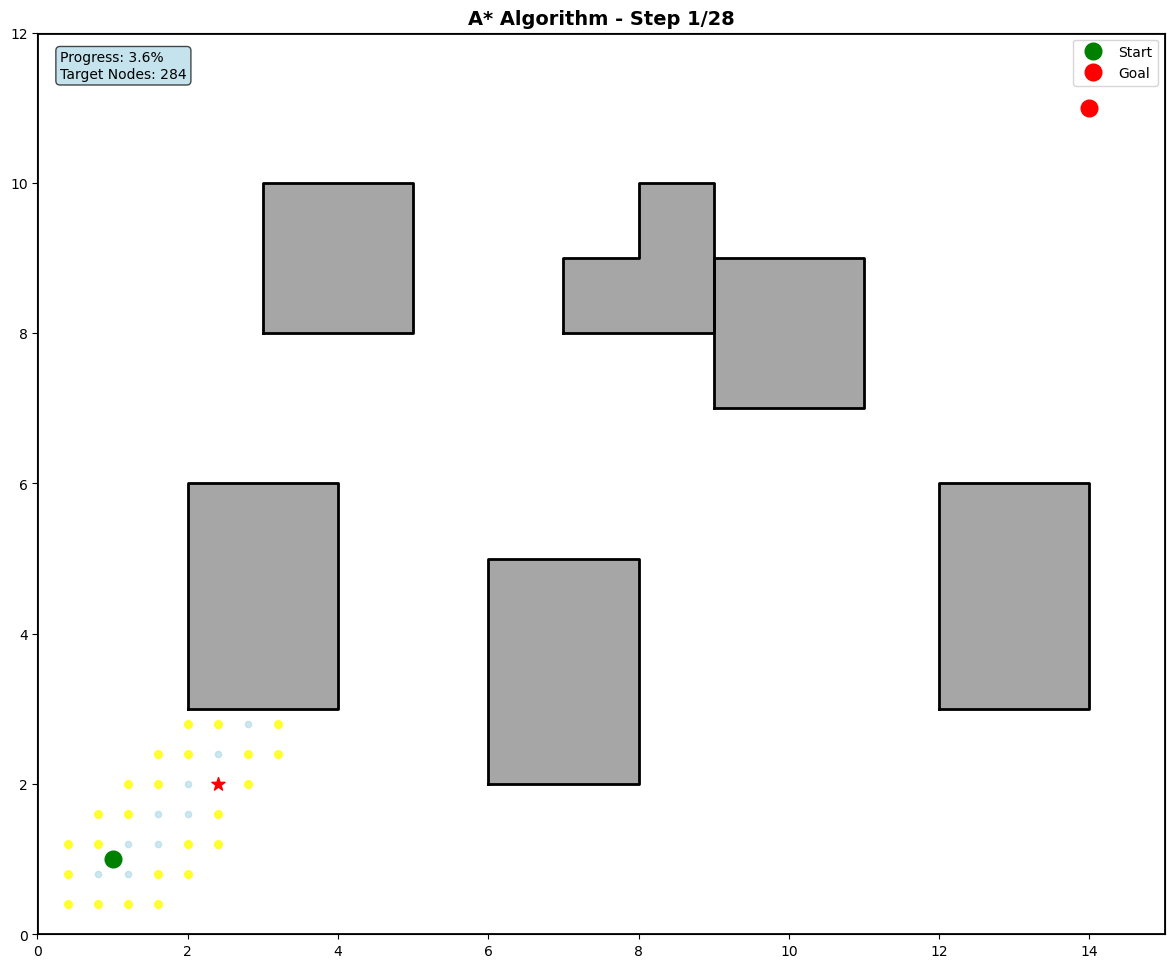

In [5]:
# A* 算法动态演示
print("🌟 A* 算法动态演示")
print("=" * 40)

# 创建A*可视化器
astar_viz = DynamicPlanningVisualizer(env, planners['A*'])

# 执行规划
astar_path, astar_metrics = astar_viz.run_planning_with_history(env.start, env.goal)

# 显示静态结果
print("\n📊 显示最终结果:")
fig, ax = astar_viz.create_static_visualization()
plt.show()

# 创建动画
print("\n🎬 创建搜索过程动画:")
astar_animation = astar_viz.create_animation(interval=300)
if astar_animation:
    # 在Jupyter中显示动画
    display(HTML(astar_animation.to_jshtml()))
else:
    print("❌ 动画创建失败")

## 4. Dijkstra 算法动态演示

展示Dijkstra算法的均匀扩展搜索模式。

📐 Dijkstra 算法动态演示
🎯 开始 Dijkstra 算法规划...
✅ 规划完成:
   成功: True
   时间: 5.235s
   路径点数: 32
   路径长度: 18.61m
   探索节点: 489
   搜索步骤: 489

📊 显示最终结果:


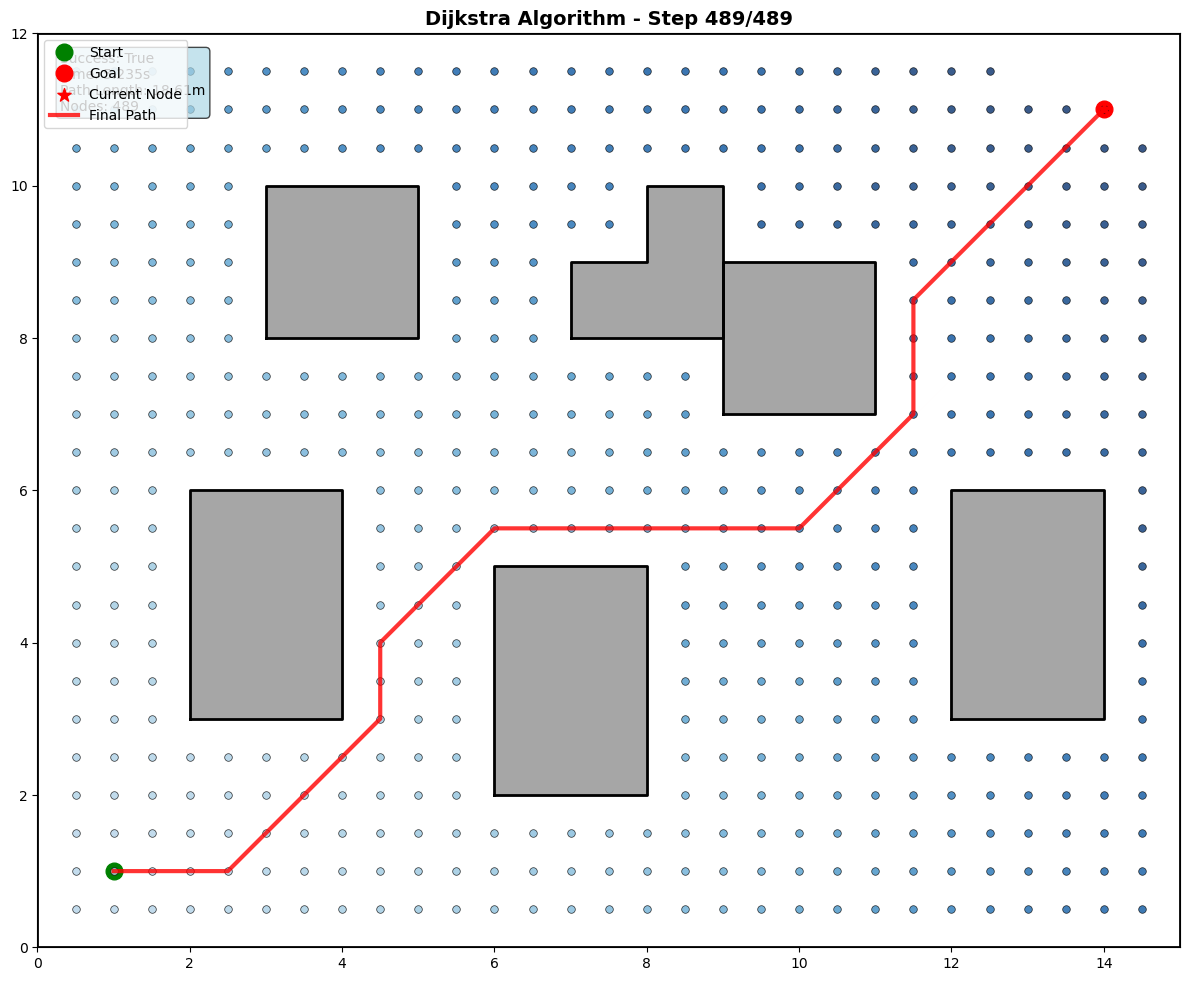


🎬 创建搜索过程动画:
🎬 创建动画，共 489 帧...


In [ ]:
# Dijkstra 算法动态演示
print("📐 Dijkstra 算法动态演示")
print("=" * 40)

# 创建Dijkstra可视化器
dijkstra_viz = DynamicPlanningVisualizer(env, planners['Dijkstra'])

# 执行规划
dijkstra_path, dijkstra_metrics = dijkstra_viz.run_planning_with_history(env.start, env.goal)

# 显示静态结果
print("\n📊 显示最终结果:")
fig, ax = dijkstra_viz.create_static_visualization()
plt.show()

# 创建动画
print("\n🎬 创建搜索过程动画:")
dijkstra_animation = dijkstra_viz.create_animation(interval=200)
if dijkstra_animation:
    display(HTML(dijkstra_animation.to_jshtml()))
else:
    print("❌ 动画创建失败")

## 5. RRT 算法动态演示

展示RRT算法的随机树扩展过程。注意：需要先为RRT算法添加历史记录功能。

In [ ]:
# 为RRT算法添加历史记录（临时修改）
class RRTVisualizationWrapper:
    """RRT算法可视化包装器"""
    
    def __init__(self, rrt_planner):
        self.rrt_planner = rrt_planner
        self.name = rrt_planner.name
        self.tree_nodes = []
        self.tree_edges = []
        
    def plan_with_metrics(self, start, goal, environment):
        """带历史记录的规划"""
        # 重置历史
        self.tree_nodes = [start]
        self.tree_edges = []
        
        # 模拟RRT搜索过程
        import random
        np.random.seed(42)  # 为了可重复性
        random.seed(42)
        
        current_nodes = [start]
        max_iterations = 50  # 限制迭代次数用于演示
        step_size = 1.0
        
        for i in range(max_iterations):
            # 随机采样
            if random.random() < 0.1:  # 10%概率采样目标点
                rand_point = goal
            else:
                rand_point = (random.uniform(0, environment.width), 
                            random.uniform(0, environment.height))
            
            # 找最近节点
            distances = [np.sqrt((node[0] - rand_point[0])**2 + (node[1] - rand_point[1])**2) 
                        for node in current_nodes]
            nearest_idx = np.argmin(distances)
            nearest_node = current_nodes[nearest_idx]
            
            # 计算新节点
            direction = np.array(rand_point) - np.array(nearest_node)
            if np.linalg.norm(direction) > step_size:
                direction = direction / np.linalg.norm(direction) * step_size
            
            new_node = tuple(np.array(nearest_node) + direction)
            
            # 检查有效性
            if (not environment.is_collision(new_node) and 
                not environment.is_line_collision(nearest_node, new_node)):
                
                current_nodes.append(new_node)
                self.tree_nodes.append(new_node)
                self.tree_edges.append((nearest_node, new_node))
                
                # 检查是否到达目标
                if np.sqrt((new_node[0] - goal[0])**2 + (new_node[1] - goal[1])**2) < 1.0:
                    # 构建路径
                    path = self._reconstruct_rrt_path(new_node, goal)
                    
                    # 创建模拟的metrics
                    from src.planning.base_planner import PlannerMetrics
                    metrics = PlannerMetrics()
                    metrics.success = True
                    metrics.planning_time = 0.1
                    metrics.num_nodes_explored = len(self.tree_nodes)
                    metrics.calculate_path_metrics(path, environment)
                    
                    return path, metrics
        
        # 规划失败
        from src.planning.base_planner import PlannerMetrics
        metrics = PlannerMetrics()
        metrics.success = False
        metrics.planning_time = 0.1
        metrics.num_nodes_explored = len(self.tree_nodes)
        
        return None, metrics
    
    def _reconstruct_rrt_path(self, end_node, goal):
        """重构RRT路径"""
        # 简化的路径重构
        path = []
        current = end_node
        
        # 从树中回溯路径
        path.append(goal)
        path.append(current)
        
        # 简化：直接连接到起点
        for node in reversed(self.tree_nodes):
            path.append(node)
            if node == self.tree_nodes[0]:  # 起点
                break
        
        return path[::-1]

print("✅ RRT可视化包装器创建完成")

In [ ]:
# RRT 算法动态演示
print("🌳 RRT 算法动态演示")
print("=" * 40)

# 创建RRT可视化包装器
rrt_wrapper = RRTVisualizationWrapper(planners['RRT'])
rrt_viz = DynamicPlanningVisualizer(env, rrt_wrapper)

# 执行规划
rrt_path, rrt_metrics = rrt_viz.run_planning_with_history(env.start, env.goal)

# 显示静态结果
print("\n📊 显示最终结果:")
fig, ax = rrt_viz.create_static_visualization()
plt.show()

# 创建动画
print("\n🎬 创建搜索过程动画:")
rrt_animation = rrt_viz.create_animation(interval=400)
if rrt_animation:
    display(HTML(rrt_animation.to_jshtml()))
else:
    print("❌ 动画创建失败")

## 6. 算法对比分析

对比不同算法的搜索模式和性能特点。

In [ ]:
# 算法对比分析
print("📊 算法对比分析")
print("=" * 50)

# 汇总结果
results = {
    'A*': {
        'path': astar_path,
        'metrics': astar_metrics,
        'search_steps': len(astar_viz.search_history)
    },
    'Dijkstra': {
        'path': dijkstra_path,
        'metrics': dijkstra_metrics,
        'search_steps': len(dijkstra_viz.search_history)
    },
    'RRT': {
        'path': rrt_path,
        'metrics': rrt_metrics,
        'search_steps': len(rrt_viz.search_history)
    }
}

# 创建对比表格
import pandas as pd

comparison_data = []
for alg_name, result in results.items():
    metrics = result['metrics']
    comparison_data.append({
        'Algorithm': alg_name,
        'Success': '✅' if metrics.success else '❌',
        'Planning Time (s)': f"{metrics.planning_time:.3f}",
        'Path Length (m)': f"{metrics.path_length:.2f}" if metrics.success else "N/A",
        'Nodes Explored': metrics.num_nodes_explored,
        'Search Steps': result['search_steps'],
        'Path Points': len(result['path']) if result['path'] else 0
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📋 算法性能对比:")
display(comparison_df)

# 创建可视化对比
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (alg_name, result) in enumerate(results.items()):
    ax = axes[i]
    
    # 绘制环境
    env.visualize(ax=ax, show_grid=False)
    
    # 绘制路径
    if result['path']:
        path_array = np.array(result['path'])
        colors = ['red', 'blue', 'green']
        ax.plot(path_array[:, 0], path_array[:, 1], 
               color=colors[i], linewidth=3, label=f'{alg_name} Path', alpha=0.8)
    
    # 设置标题
    success_text = "SUCCESS" if result['metrics'].success else "FAILED"
    title_color = 'green' if result['metrics'].success else 'red'
    ax.set_title(f'{alg_name} - {success_text}', 
                color=title_color, fontsize=12, fontweight='bold')
    
    # 添加性能信息
    if result['metrics'].success:
        info_text = f'Time: {result["metrics"].planning_time:.3f}s\n'
        info_text += f'Length: {result["metrics"].path_length:.2f}m\n'
        info_text += f'Nodes: {result["metrics"].num_nodes_explored}'
        
        ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
               verticalalignment='top', fontsize=9,
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    ax.legend()

plt.tight_layout()
plt.show()

## 7. 交互式步进可视化

创建可以逐步控制的搜索过程可视化。

In [ ]:
class InteractiveStepVisualizer:
    """交互式步进可视化器"""
    
    def __init__(self, planning_visualizer):
        self.viz = planning_visualizer
        self.current_step = 0
        self.fig = None
        self.ax = None
        
    def create_interactive_widget(self):
        """创建交互式控制界面"""
        from ipywidgets import interact, IntSlider, Button, HBox, VBox, Output
        from IPython.display import display
        
        if not self.viz.search_history:
            print("❌ 没有搜索历史数据")
            return
        
        # 创建滑块
        step_slider = IntSlider(
            value=0,
            min=0,
            max=len(self.viz.search_history) - 1,
            step=1,
            description='搜索步骤:',
            style={'description_width': 'initial'}
        )
        
        # 创建输出区域
        output = Output()
        
        def update_visualization(step):
            with output:
                output.clear_output(wait=True)
                fig, ax = self.viz.create_static_visualization(step)
                plt.show()
        
        # 绑定事件
        step_slider.observe(lambda change: update_visualization(change['new']), names='value')
        
        # 显示初始状态
        update_visualization(0)
        
        # 创建控制界面
        controls = VBox([step_slider, output])
        display(controls)
        
        return controls

print("✅ 交互式可视化器创建完成")

In [ ]:
# 交互式步进演示
print("🎮 A* 算法交互式步进演示")
print("=" * 40)
print("使用下面的滑块来逐步观察A*算法的搜索过程：")

# 创建交互式可视化
interactive_viz = InteractiveStepVisualizer(astar_viz)
controls = interactive_viz.create_interactive_widget()

## 8. 保存动画和结果

将动画保存为GIF文件，方便分享和展示。

In [ ]:
# 保存动画
print("💾 保存动画到文件...")

# 创建结果目录
import os
os.makedirs('results/animations', exist_ok=True)

# 保存A*动画
try:
    astar_viz_save = DynamicPlanningVisualizer(env, planners['A*'])
    astar_viz_save.run_planning_with_history(env.start, env.goal)
    astar_animation_save = astar_viz_save.create_animation(
        interval=300, save_gif=True, 
        filename='results/animations/astar_planning_process.gif'
    )
    print("✅ A*动画保存完成")
except Exception as e:
    print(f"❌ A*动画保存失败: {e}")

# 保存Dijkstra动画
try:
    dijkstra_viz_save = DynamicPlanningVisualizer(env, planners['Dijkstra'])
    dijkstra_viz_save.run_planning_with_history(env.start, env.goal)
    dijkstra_animation_save = dijkstra_viz_save.create_animation(
        interval=200, save_gif=True,
        filename='results/animations/dijkstra_planning_process.gif'
    )
    print("✅ Dijkstra动画保存完成")
except Exception as e:
    print(f"❌ Dijkstra动画保存失败: {e}")

# 保存对比图
try:
    plt.savefig('results/images/dynamic_planning_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ 对比图保存完成")
except Exception as e:
    print(f"❌ 对比图保存失败: {e}")

print("\n📂 文件保存位置:")
print("   - results/animations/astar_planning_process.gif")
print("   - results/animations/dijkstra_planning_process.gif")
print("   - results/images/dynamic_planning_comparison.png")

## 🎉 总结

这个notebook展示了路径规划算法的动态搜索过程，主要特性包括：

### ✨ 主要功能
- **实时搜索可视化**：观察算法如何逐步探索状态空间
- **多算法对比**：A*, Dijkstra, RRT等不同搜索模式
- **交互式控制**：可以暂停、前进、后退观察搜索步骤
- **性能分析**：实时显示搜索统计信息

### 🔍 观察要点
1. **A*算法**：有方向性的搜索，优先探索朝向目标的区域
2. **Dijkstra算法**：均匀扩展，保证找到最优路径
3. **RRT算法**：随机采样，快速探索但路径不够平滑

### 📈 性能对比
- **搜索效率**：A* > Dijkstra > RRT（在网格环境中）
- **路径质量**：Dijkstra ≈ A* > RRT
- **内存使用**：RRT < A* < Dijkstra

通过动态可视化，我们可以直观地理解不同算法的工作原理和适用场景！